<a href="https://colab.research.google.com/github/IvanLudvig/mlmipt/blob/master/pytorch/pytorch_matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# all config/downloads to use fastai
# !pip install pandas --upgrade
#!pip install plotly --upgrade
#!pip install fastai==0.7.0
#!pip install torchtext==0.2.3
!pip install torch
#!pip install torchvision
#!pip install Pillow>=4.1.1
#!pip install image
#!pip install matplotlib

In [2]:
from google.colab import drive
drive.mount('/mnt')

Drive already mounted at /mnt; to attempt to forcibly remount, call drive.mount("/mnt", force_remount=True).


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data_pd = pd.read_csv('/mnt/MyDrive/ml/pytorch/ratings.csv')
movies_pd = pd.read_csv('/mnt/MyDrive/ml/pytorch/movies.csv')
data_pd = data_pd.sample(frac=1)

In [5]:
data_pd.head()

,userId,movieId,rating,timestamp
69567,448,7046,3.0,1074423410
1503,15,5971,2.0,1510577982
70491,448,158872,4.0,1497034759
29222,200,44761,5.0,1229878699
55844,368,3844,3.0,971273801


In [6]:
u_temp = list(data_pd.userId.unique())
u_temp.sort()

m_temp = list(data_pd.movieId.unique())
m_temp.sort()

In [7]:
movie_dict = dict(list(zip(m_temp,range(len(m_temp)))))
user_dict = dict(list(zip(u_temp,range(len(u_temp)))))

In [8]:
data_pd['userId'] = data_pd['userId'].map(lambda x: user_dict[x])
data_pd['movieId'] = data_pd['movieId'].map(lambda x: movie_dict[x])

In [9]:
X = data_pd[['userId','movieId']].values
y = data_pd[['rating']].values

In [10]:
films = np.transpose(X)[1]

counts = np.bincount(films)
print(np.argmax(counts))

314


In [11]:
y = y.astype(np.float)

In [12]:
type(np.float(1.))

float

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
class RatingDataset():
  def __init__(self, train, label):
    self.feature_= train
    self.label_= label
  def __len__(self):
    #return size of dataset
    return len(self.feature_)
  def __getitem__(self, idx):
    return torch.tensor(self.feature_[idx]),torch.tensor(self.label_[idx])

In [15]:
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

In [16]:
bs = 5000
train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

In [17]:
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)
        
    def forward(self, user, item):
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        #pred = pred.float()
        pred.to('cuda')
        return pred.squeeze()

In [18]:
n, m =  len(data_pd.userId.unique()), len(data_pd.movieId.unique())

In [19]:
nfactor = 300
model = MatrixFactorization(n, m, n_factors=nfactor)

In [20]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# dev = torch.device("cpu")

In [21]:
model.parameters

<bound method Module.parameters of MatrixFactorization(
  (user_factors): Embedding(610, 300)
  (item_factors): Embedding(9724, 300)
  (user_biases): Embedding(610, 1)
  (item_biases): Embedding(9724, 1)
)>

In [22]:
dev

device(type='cuda')

In [23]:
loss_func = torch.nn.MSELoss()
model.to(dev)

MatrixFactorization(
  (user_factors): Embedding(610, 300)
  (item_factors): Embedding(9724, 300)
  (user_biases): Embedding(610, 1)
  (item_biases): Embedding(9724, 1)
)

In [24]:
model.parameters
model.double()

MatrixFactorization(
  (user_factors): Embedding(610, 300)
  (item_factors): Embedding(9724, 300)
  (user_biases): Embedding(610, 1)
  (item_biases): Embedding(9724, 1)
)

In [ ]:
epoches = 1000
train_loss_data = []
test_loss_data = []
for epoch in range(0, epoches):
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))  # progress bar
    count = 0
    cum_loss = 0.
    for i,( train_batch, label_batch) in pbar:
        count = 1 + i
        # Predict and calculate loss for user factor and bias
        optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
        prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
        
        loss = loss_func(prediction, label_batch.to(dev))    
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()
        
        #predict and calculate loss for item factor and bias
        optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
        prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
        loss = loss_func(prediction, label_batch.to(dev))
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()
        
        cum_loss += loss.item()
        pbar.set_description('training loss at {} batch {}: {}'.format(epoch,i,loss.item()))
    train_loss = cum_loss/count
    pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))  # progress bar
    cum_loss =0.
    count = 0
    for i,( test_batch, label_batch) in pbar:
        count = 1 + i
        with torch.no_grad():
            prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            cum_loss += loss.item()
            pbar.set_description('test loss at {} batch {}: {}'.format(epoch,i,loss.item()))
    test_loss = cum_loss/count
    train_loss_data.append(train_loss)
    test_loss_data.append(test_loss)

    diff = np.mean(np.diff(test_loss_data)[:-10])
    print('avg training loss: ', round(train_loss, 3), ' avg test loss: ',round(test_loss, 3), ' diff: ', round(diff, 3))
    if (np.mean(np.diff(test_loss_data)[:-10]) >= -0.02):
      break

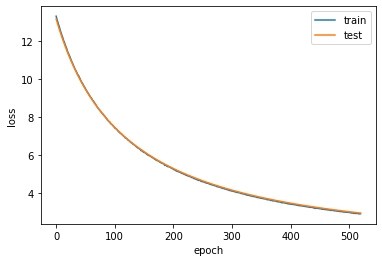

In [26]:
plt.plot(train_loss_data, label='train')
plt.plot(test_loss_data, label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [27]:
np_items = model.item_factors.weight.data.cpu().numpy()
np_users = model.user_factors.weight.data.cpu().numpy()
np_item_bias = model.item_biases.weight.data.cpu().numpy()
np_user_bias = model.user_biases.weight.data.cpu().numpy()

In [28]:
def cosine_similarity(a, b):
  return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [29]:
movie_id = movie_dict[2571] # the matrix
sim_dict = {}
for m, id in zip(np_items, movie_dict.keys()):
  sim_dict[id] = cosine_similarity(np_items[movie_id], m)

In [30]:
sim_pd = pd.DataFrame(sim_dict.items(), columns=['movieId', 'similarity'])
sim_pd = sim_pd.merge(movies_pd, on='movieId')

Топ 30 фильмов, наиболее похожих на фильм Матрица.
Недостаток подхода в поиске похожих фильмов по косинусной мере в том, что не учитывается bias

In [31]:
sim_pd.sort_values('similarity', ascending=False)[0:30][['title', 'genres', 'similarity']]

,title,genres,similarity
1938,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1.000000
81,Mary Reilly (1996),Drama|Horror|Thriller,0.208192
563,"Alphaville (Alphaville, une étrange aventure d...",Drama|Mystery|Romance|Sci-Fi|Thriller,0.202180
4366,Siam Sunset (1999),Comedy,0.194249
1152,Children of the Revolution (1996),Comedy,0.184851
637,Kazaam (1996),Children|Comedy|Fantasy,0.181895
2546,"Bear, The (Ours, L') (1988)",Adventure|Children|Drama,0.181517
5777,Howl's Moving Castle (Hauru no ugoku shiro) (2...,Adventure|Animation|Fantasy|Romance,0.179897
3326,"Great Outdoors, The (1988)",Comedy,0.179537
3633,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,0.179319


In [46]:
userId = 88
user_np = np_users[userId]
watched = np.transpose(data_pd[data_pd['userId'] == user_dict[42]][['movieId']].to_numpy())[0]
print(f"user {userId} watched {len(watched)} films")

user 88 watched 440 films


In [47]:
ratings_pred = np_items.dot(np_users[userId])

In [54]:
ratings_dict = {}
user_bias = np_user_bias[userId][0]
for pred, item_bias, id in zip(ratings_pred, np_item_bias, movie_dict.keys()):
  if not id in watched:
    ratings_dict[id] = pred + item_bias[0] + user_bias

In [55]:
ratings_pd = pd.DataFrame(ratings_dict.items(), columns=['movieId', 'rating'])
ratings_pd = ratings_pd.merge(movies_pd, on='movieId')

Топ 30 фильмов для пользователя

In [56]:
ratings_pd.sort_values('rating', ascending=False)[0:30][['title', 'genres', 'rating']]

,title,genres,rating
259,Forrest Gump (1994),Comedy|Drama|Romance|War,4.607818
218,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.561965
1662,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.489964
418,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.482793
83,Braveheart (1995),Action|Drama|War,4.317499
374,Schindler's List (1993),Drama|War,4.262557
189,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.252091
102,Apollo 13 (1995),Adventure|Drama|IMAX,4.210613
1931,Fight Club (1999),Action|Crime|Drama|Thriller,4.183253
416,Terminator 2: Judgment Day (1991),Action|Sci-Fi,4.178107
